In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/hate_speech/models

/content/drive/MyDrive/hate_speech/models


In [4]:
! pip install transformers==4.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 17.8 MB/s eta 0:00:00


In [5]:
import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
     

In [6]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)

In [7]:
def do_tokenize(csv, tokenizer, device):
    '''
    run the tokenizer, pad the sequence
    returns: a dataset containing input_ids, attention_masks, labels
    '''
    tweets = csv.tweet.values
    labels = csv.label.values
    # calculate max length of the tweets
    max_length = 0
    for t in tweets:
        ids = tokenizer.encode(t)
        max_length = max(len(ids),max_length)
    # get input ids and attention_masks of the tokens
    input_ids = []
    attention_masks = []
    for t in tweets:
        input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        input_ids.append(input_dict['input_ids'])
        attention_masks.append(input_dict['attention_mask'])
    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    labels = torch.tensor(labels)
    return input_ids.to(device), attention_masks.to(device), labels.to(device)    

In [8]:
def calculate_acc(output, labels):
    preds = torch.argmax(output, dim=1)
    return torch.eq(labels, preds).sum().item() / labels.size(0)

In [9]:
def train(model, iterator, optimizer):
    train_loss = 0
    train_acc = 0
    model.train()
    for input_ids, masks, labels in tqdm(iterator):
        loss, output = model(input_ids, attention_mask=masks, labels=labels,return_dict=False)
        acc = calculate_acc(output, labels)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc
    return train_loss / len(iterator), train_acc / len(iterator)

In [10]:
def evaluate(model, iterator):
    eval_loss = 0
    eval_acc = 0
    model.eval()
    with torch.no_grad():
        for input_ids, masks, labels in tqdm(iterator):
            loss, output = model(input_ids, attention_mask=masks, labels=labels,return_dict=False)
            acc = calculate_acc(output, labels)
            eval_loss += loss.item()
            eval_acc += acc
    return eval_loss / len(iterator), eval_acc / len(iterator)

In [11]:
EPOCHS = 1#0
BATCH_SIZE = 16
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
train_csv = pd.read_csv('../data/Davidson/train.csv', names=['label','tweet'],header=0)
dev_csv = pd.read_csv('../data/Davidson/dev.csv', names=['label','tweet'], header=0)
train_inputs, train_mask, train_labels = do_tokenize(train_csv, tokenizer, DEVICE)
dev_inputs, dev_mask, dev_labels = do_tokenize(dev_csv, tokenizer, DEVICE)
train_dataset = TensorDataset(train_inputs, train_mask, train_labels)
dev_dataset = TensorDataset(dev_inputs, dev_mask, dev_labels)
train_loader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = BATCH_SIZE)
dev_loader = DataLoader(dev_dataset, sampler = SequentialSampler(dev_dataset), batch_size = BATCH_SIZE)

In [14]:
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 3).to(DEVICE)
optimizer = AdamW(model.parameters(),lr = LEARNING_RATE)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.2.attention.v_lin.bias', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.4.attention.v_lin.bias', 'distilbert.transformer.layer.4.ffn.lin2.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.1.attention.v_lin.bias', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.1.attention.k_lin.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.5.ffn.lin1.bias', 'distilbert.transformer.layer.2.sa_layer_norm.bias', 'distilbert.transformer.layer.5.attention.out_lin

In [15]:
best_dev_acc = 0
best_epoch = 0
print(f'Start training...')
train_accs, dev_accs, train_losses, dev_losses = [], [],[], []
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer)
    dev_loss, dev_acc = evaluate(model, dev_loader)
    train_accs.append(train_acc)
    dev_accs.append(dev_acc)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    print(f'Epoch {epoch + 1}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
    print(f'Epoch {epoch + 1}: dev loss: {dev_loss:.4f}, dev acc: {dev_acc:.4f}')
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        best_epoch = epoch + 1
        torch.save(model, "bert.model")
        print(f'*** Epoch {epoch + 1}: dev acc higher than best dev acc, model saved!')
sec = time.time()-start_time
print(f'Training finished! Best epoch is {best_epoch}, best dev acc is {best_dev_acc:.4f}, {sec} seconds used.')

Start training...


100%|██████████| 155/155 [00:43<00:00,  3.60it/s]


Epoch 1: train loss: 0.7094, train acc: 0.7712
Epoch 1: dev loss: 0.6894, dev acc: 0.7814
*** Epoch 1: dev acc higher than best dev acc, model saved!
Training finished! Best epoch is 1, best dev acc is 0.7814, 1776.4250020980835 seconds used.


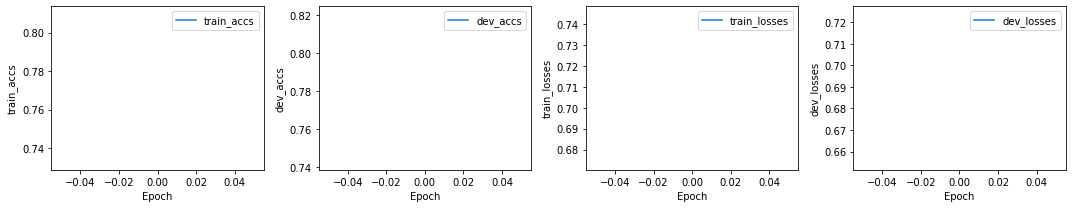

In [16]:
results = dict()
results["train_accs"] = train_accs
results["dev_accs"] = dev_accs
results["train_losses"] = train_losses
results["dev_losses"] = dev_losses
fig, plots = plt.subplots(ncols=4, figsize=(15,3))
for (category, result), plot in zip(results.items(), plots.flatten()):
  plot.plot(result, label=category)
  plot.set_xlabel('Epoch')
  plot.set_ylabel(category)
  plot.legend()
fig.tight_layout()

##### test

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [23]:
# test the final model with test file
test_csv = pd.read_csv('../data/Davidson/test.csv', names=['label','tweet'], header=0)
test_inputs, test_mask, test_labels = do_tokenize(dev_csv, tokenizer, DEVICE)
test_dataset = TensorDataset(test_inputs, test_mask, test_labels)
test_loader = DataLoader(test_dataset, sampler = SequentialSampler(dev_dataset), batch_size = BATCH_SIZE)
best_model = torch.load("bert.model", map_location=DEVICE)
best_model.eval()
preds_list = []
labels_list = []
with torch.no_grad():
    for input_ids, masks, labels in tqdm(test_loader):
        loss, output = model(input_ids, attention_mask=masks, labels=labels,return_dict=False)
        preds = torch.argmax(output, dim=1)
        preds_list.extend(preds.cpu())
        labels_list.extend(labels.cpu())


100%|██████████| 155/155 [00:44<00:00,  3.46it/s]


Normalized confusion matrix
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


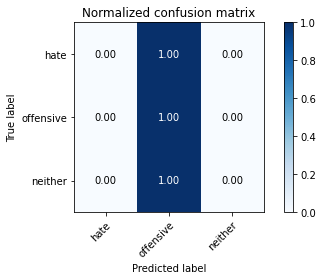

In [24]:
plot_confusion_matrix(labels_list, preds_list, classes = ["hate","offensive","neither"], normalize=True, title='Normalized confusion matrix')

Confusion matrix, without normalization
[[   0  150    0]
 [   0 1936    0]
 [   0  392    0]]


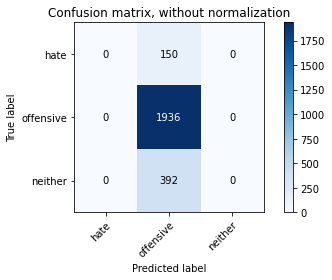

In [27]:
plot_confusion_matrix(labels_list, preds_list, classes = ["hate","offensive","neither"], normalize=False, title='Confusion matrix, without normalization')

In [26]:
print(classification_report(labels_list, preds_list, target_names=["hate","offensive","neither"]))

              precision    recall  f1-score   support

        hate       0.00      0.00      0.00       150
   offensive       0.78      1.00      0.88      1936
     neither       0.00      0.00      0.00       392

    accuracy                           0.78      2478
   macro avg       0.26      0.33      0.29      2478
weighted avg       0.61      0.78      0.69      2478



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
